In [1]:
import vaex
import vaex.jupyter.model as vjm

import numpy as np
from numpy import r_
import pandas as pd
import matplotlib.pyplot as plt

import mhealpy as mh

from numba import jit, int64, vectorize

In [2]:
df = vaex.open('./atl06_03_S.arrow')
df

#,id,lat,lon,slope_y,slope_x,slope_x_sigma,h_li,s_li,q_flag,s_fg,snr,h_rb,bsnow_conf,cloud_flg_asr,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final,t_year,cycle,track,midx,x,y
0,1411891,-73.42552448629439,-23.737491529404053,3.4028234663852886e+38,0.003976050298660994,0.004737921059131622,-0.928657591342926,0.05943682789802551,0,0,0.0,0.31860873103141785,-1,5,3,2,29.979246139526367,3.3278605937957764,1,7129.5341796875,0.0,32,3.0,2019-05-15 18:32:18.937870,3,gt1l,5121313434313234232,-727639.2099292141,1654665.7247102554
1,1411892,-73.42570108740605,-23.737578914273882,3.4028234663852886e+38,-0.002587417373433709,0.005404622759670019,-1.074399471282959,0.18140001595020294,0,0,0.0,0.3358314335346222,-1,5,2,2,29.979246139526367,3.323024272918701,1,9199.2119140625,0.0,30,3.0,2019-05-15 18:32:18.940693,3,gt1l,5121313434313234231,-727633.8756359789,1654646.745975993
2,1411893,-73.42587767946493,-23.737666524006926,-0.0034792206715792418,0.005786192137748003,0.009921900928020477,-0.9788220524787903,0.1321229785680771,0,0,0.0,0.593020498752594,-1,5,2,2,29.979246139526367,3.3182029724121094,1,9166.1826171875,0.0,35,3.5581231117248535,2019-05-15 18:32:18.943507,3,gt1l,5121313434313234231,-727628.5481865024,1654627.7653298955
3,1411894,-73.42605427224831,-23.73775412633728,0.0016622913535684347,-0.019352739676833153,0.0043994830921292305,-1.0710368156433105,0.1024324968457222,0,0,0.0,0.36016562581062317,-1,5,2,2,29.979246139526367,3.3133904933929443,1,7230.70849609375,0.0,48,3.0,2019-05-15 18:32:18.946315,3,gt1l,5121313434313234142,-727623.2204380583,1654608.7847323737
4,1411895,-73.42623086896181,-23.737841655037016,0.004035372287034988,0.008749883621931076,0.0038084150291979313,-1.219468116760254,0.060207393020391464,0,0,0.0,0.30477914214134216,-1,5,2,2,29.979246139526367,3.3085813522338867,1,5390.36962890625,0.0,48,3.0,2019-05-15 18:32:18.949122,3,gt1l,5121313434313234123,-727617.8903354848,1654589.8047001245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,463,893,173",1569656,-78.2400490932243,-112.14232913945352,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-3,5,2,2,29.979246139526367,-0.007984576746821404,1,9233.5322265625,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:03:34.767862,3,gt3r,4112233333421444212,-1183965.1241931545,-481777.6041658824
"1,463,893,174",1569657,-78.2398740994634,-112.14249557765775,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-3,5,2,2,29.979246139526367,-0.008194150403141975,1,8526.9384765625,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:03:34.770912,3,gt3r,4112233333421444221,-1183981.4619760022,-481788.2611581817
"1,463,893,175",1569752,-78.22323544581869,-112.157929146986,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-1,5,2,2,29.979246139526367,-0.028147201985120773,1,7081.39306640625,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:03:35.038195,3,gt3r,4112233333424244132,-1185537.9685311797,-482793.90209957986
"1,463,893,176",1579859,-76.449328422305,-113.6012793545775,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-1,5,1,1,3.4028234663852886e+38,3.4028234663852886e+38,1,7556.9716796875,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:04:03.526662,3,gt3r,4112412432332143114,-1351174.6645843042,-590349.6253547024


In [3]:
times = df.t_year.as_numpy().values

In [4]:
np.min(times[5:]), np.max(times)

(numpy.datetime64('2019-03-29T00:56:43.160680000'),
 numpy.datetime64('2019-06-26T14:50:35.509651000'))

In [5]:
!du -csh ./atl06_03_S.arrow

164G	./atl06_03_S.arrow
164G	total


As we can see, this 91-day orbit includes 865,273,103 observations, packed in a file that is 91 gigabytes large. We can plot data with some simple resampling to polar sterographic south bins, which are already encoded as the x and y columns in the vaex array

In [6]:
x_axis = vjm.Axis(df=df, expression=df.x, shape=1000)
y_axis = vjm.Axis(df=df, expression=df.y, shape=1000)
y_axis

Axis(bin_centers=None, exception=None, expression=y, max=None, min=None, shape=1000, shape_default=64, slice=None, status=Status.NO_LIMITS)

In [7]:
await vaex.jupyter.gather()  # wait until Vaex is done with all background computation

In [8]:
data_array_widget = df.widget.data_array(axes=[y_axis, x_axis], selection=[None, 'default'])
data_array_widget  # being the last expression in the cell, Jupyter  will 'display' the widget

DataArray(children=[Container(children=[ProgressCircularNoAnimation(color='#9ECBF5', size=30, text='', value=1…

In [9]:
await vaex.jupyter.gather()
# get a reference to the xarray DataArray object
data_array = data_array_widget.model.grid

In [10]:
data_array

<xarray.DataArray (selection: 1, y: 1000, x: 1000)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * selection  (selection) object None
  * y          (y) float64 -2.54e+06 -2.534e+06 ... 3.98e+06 3.986e+06
  * x          (x) float64 -4.35e+06 -4.342e+06 ... 3.975e+06 3.983e+06

In [11]:
data_array.dims

('selection', 'y', 'x')

In [12]:
data_array.coords

Coordinates:
  * selection  (selection) object None
  * y          (y) float64 -2.54e+06 -2.534e+06 ... 3.98e+06 3.986e+06
  * x          (x) float64 -4.35e+06 -4.342e+06 ... 3.975e+06 3.983e+06

To be perfectly explicit about what is happening and what is about to happen-- we've initiated a template xarray grid, that we'll fill and plot with data that we calculate from the vaex array.

In [13]:
df.select(df.q_flag == 1)

In [14]:
# NOTE: da is short for 'data array'
def plot2d(da):
    plt.figure(figsize=(8, 8))
    ar = da.data[0]  # take the numpy data, and select take the selection
    print(f'imshow of a numpy array of shape: {ar.shape}')
    plt.imshow(np.log1p(ar.T), origin='lower')

df.widget.data_array(axes=[x_axis, y_axis], display_function=plot2d, selection=['default'])

DataArray(children=[Container(children=[ProgressCircularNoAnimation(color='#9ECBF5', size=30, text='', value=1…

Currently there's a bit of bug on the interactive widget-- updates to the figure need to be explicitly rerun, or run twice...

In [15]:
selection_widget = df.widget.selection_expression()
selection_widget

ExpressionSelectionTextArea(label='Filter by custom expression', placeholder='Enter a custom (boolean) express…

In [16]:
await vaex.jupyter.gather()
w = df.widget.counter_selection('default', lazy=True)
w

Counter(characters=['&nbsp;', '&nbsp;', '&nbsp;', '&nbsp;', '6', '6', ',', '4', '7', '0', ',', '4', '6', '9'],…

Tiling
--------

The `mhealpy` library is an superset of the `healpy` library that adds support for multiresolution healpix maps:

![fig2](fig4.png "Title")

The astronomy community uses a different indexing scheme then the 'morton' ordering discribed in the previous section. There's actually three different schemes that are provided for: `ring`, `nested` and `uniq`, with the first two being fixed resolution, and the last being multiresolution.

The multiresolution scheme has interesting implications for satellite data; for one thing, orbital convergence means that the sample resolution increases towards the poles, and decreases towards the equator. With the multiresolution naming scheme, it's perfectly reasonable to change the tesselation order to balance roughly equivelent numbers of observations per shard. For now we'll keep to a fixed layout, mainly so that query operations are still straightforward to formulate and execute, but it's worth keeping the application in mind.

There are facilities for converting between to representations, and certain index methods are optimized for different types of plotting methods. We can visulize our data location and extent using the built in methods.

In [17]:
# How to access raw data values to pass to functions
df.lat.as_numpy().values

array([-73.42552449, -73.42570109, -73.42587768, ..., -78.22323545,
       -76.44932842, -76.425415  ])

We have to decide on a chunk size. It's not totally obvious how to do this, but we can guess based on the mean cell center spacing, which is simple to calculate:

In [18]:
def order2res(order):
    res = 111* 58.6323*.5**order
    return res

for res in range(20):
    print(str(order2res(res))+ ' km at tesselation order ' + str(res))

6508.1853 km at tesselation order 0
3254.09265 km at tesselation order 1
1627.046325 km at tesselation order 2
813.5231625 km at tesselation order 3
406.76158125 km at tesselation order 4
203.380790625 km at tesselation order 5
101.6903953125 km at tesselation order 6
50.84519765625 km at tesselation order 7
25.422598828125 km at tesselation order 8
12.7112994140625 km at tesselation order 9
6.35564970703125 km at tesselation order 10
3.177824853515625 km at tesselation order 11
1.5889124267578125 km at tesselation order 12
0.7944562133789063 km at tesselation order 13
0.39722810668945313 km at tesselation order 14
0.19861405334472657 km at tesselation order 15
0.09930702667236328 km at tesselation order 16
0.04965351333618164 km at tesselation order 17
0.02482675666809082 km at tesselation order 18
0.01241337833404541 km at tesselation order 19


In [ ]:
# Set static resolution... order 10?
nside = 2**10

# Convert locations to healpix
#healidx = df.apply(mh.hp.ang2pix, arguments=[df.lon, df.lat, lonlat=True])
healidx = mh.hp.ang2pix(nside,df.lon.as_numpy().values, df.lat.as_numpy().values, lonlat=True) #, nest=True)
#test = mh.containers.HealpixMap(uniq=mh.nest2uniq(nside=2**13, ipix=healidx.ravel()))
# Static map
test = mh.containers.HealpixMap(nside=nside)

In [ ]:
# just a plain numpy array
m = np.zeros(mh.hp.nside2npix(nside))
m[healidx.ravel()] += 1

In [ ]:
# Centered on the south pole
mh.hp.gnomview(m, rot=[0,-90], xsize=1200, ysize=1200)# , nest=True)

In [ ]:
len(np.unique(healidx))

In [ ]:
91000/113307

...probably too small. Chunks are under a meg. Let's bump up by three orders:

In [ ]:
# Set static resolution... order 7
nside = 2**7

# Convert locations to healpix
#healidx = df.apply(mh.hp.ang2pix, arguments=[str(nside), df.lon, df.lat, 'False', 'True'])
healidx_7 = mh.hp.ang2pix(nside,df.lon.as_numpy().values, df.lat.as_numpy().values, lonlat=True) #, nest=True)
#test = mh.containers.HealpixMap(uniq=mh.nest2uniq(nside=2**13, ipix=healidx.ravel()))
# Static map
#test = mh.containers.HealpixMap(nside=nside)

In [ ]:
len(np.unique(healidx_7))

In [ ]:
91000/1946

46 megs... seems better, lets do a few plots:

In [ ]:
uhealpix7 = np.unique(healidx_7)

In [ ]:
test = mh.containers.HealpixMap(nside=nside)
# Multilevel map, from static map
mtest = test.moc_from_pixels(nside=nside, pixels=uhealpix7.ravel() )
mtest.plot_grid(proj='gnom',rot=[0,-90],ysize=1200, xsize=1200)

...hard to tell. This level could work, but so could another order up. We'll try one more level:

In [19]:
# Set static resolution... order 
nside = 2**6

# Convert locations to healpix
#healidx = df.apply(mh.hp.ang2pix, arguments=[str(nside), df.lon, df.lat, 'False', 'True'])
healidx6 = mh.hp.ang2pix(nside,df.lon.as_numpy().values, df.lat.as_numpy().values, lonlat=True) #, nest=True)
#test = mh.containers.HealpixMap(uniq=mh.nest2uniq(nside=2**13, ipix=healidx.ravel()))
# Static map
#test = mh.containers.HealpixMap(nside=nside)

In [20]:
uhealpix6 = np.unique(healidx6)
len(uhealpix6)

1665

In [21]:
91000/540

168.5185185185185

In [22]:
168.5* 60

10110.0

/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


([<matplotlib.lines.Line2D at 0x7f3f14ab0e50>],
 <healpy.projector.GnomonicProj at 0x7f3f6168fd90>)

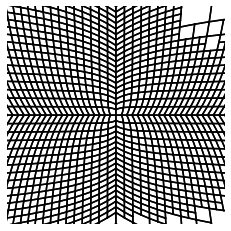

In [23]:
test = mh.containers.HealpixMap(nside=nside)
# Multilevel map, from static map
mtest = test.moc_from_pixels(nside=nside, pixels=uhealpix6.ravel() )
mtest.plot_grid(proj='gnom',rot=[0,-90],ysize=1200, xsize=1200)

How does this chunking look in practice on real data? We can visualize the chunks using the Antarctic drainage basin polygons as an example. Part of my task at Goddard is to see if the ice divide boundries are changing (i.e., are the drainage basins shifting). To do that, rather than subsetting the entire basin (i.e., the full polygon), you would want to select just along the line that defines the polygon-- or more explicitly to buffer the line at some distance and look at those values. For the data sharding case, we can look at what shards would contain the boundry:

In [32]:
basins = pd.read_csv('./Ant_Grounded_DrainageSystem_Polygons.txt')

In [33]:
b2 = basins[basins.basin == 2]

In [34]:
basins.head

<bound method NDFrame.head of                Lat        Lon  basin
0       -74.525273 -61.122545      1
1       -74.525435 -61.123664      1
2       -74.525467 -61.123826      1
3       -74.525576 -61.124567      1
4       -74.525609 -61.124498      1
...            ...        ...    ...
1238996 -74.523392 -61.109736     27
1238997 -74.523938 -61.113444     27
1238998 -74.524484 -61.117151     27
1238999 -74.525030 -61.120859     27
1239000 -74.525273 -61.122545     27

[1239001 rows x 3 columns]>

60


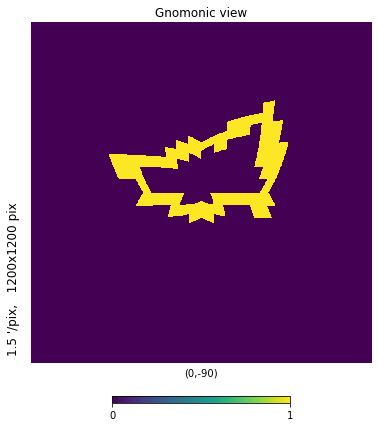

In [22]:
nside = 2**6
b2idx = mh.hp.ang2pix(nside,b2.Lon.values, b2.Lat.values, lonlat=True) 
m = np.zeros(mh.hp.nside2npix(nside))
m[np.unique(b2idx).ravel()] += 1
# Centered on the south pole
mh.hp.gnomview(m, rot=[0,-90], xsize=1200, ysize=1200)# , nest=True)
print(len(np.unique(b2idx).ravel()))

119


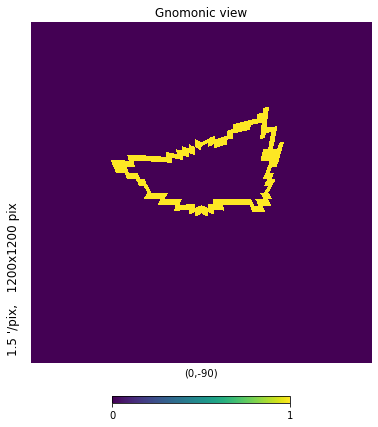

In [23]:
nside = 2**7
b2idx = mh.hp.ang2pix(nside,b2.Lon.values, b2.Lat.values, lonlat=True) 
m = np.zeros(mh.hp.nside2npix(nside))
m[np.unique(b2idx).ravel()] += 1
# Centered on the south pole
mh.hp.gnomview(m, rot=[0,-90], xsize=1200, ysize=1200)# , nest=True)
print(len(np.unique(b2idx).ravel()))

perhaps the best way to compare is to just write out both chunk sizes to aws and check the timings? Well, to do that we'll need to setup the hierarchical naming scheme...

Extending Healpix to Multiresolution Addressing
-----------------------------------------------

So far the previous 4 plots have all been plots in just generic healpix space-- not using or segmenting real data. We'll apply the healpix indices to the ATL06 dataframe, extend the indexing to include Morton indexing, and then look at a few multiresolution queries and selections

In [24]:
def unique2parent(unique):
    '''
    Assumes input is UNIQ
    Currently only works on single resolution
    Returns parent base cell
    '''
    nside = mh.uniq2nside(unique)
    if nside.all():
        order = int(np.log2(nside.max()))
    unique = unique // 4**(order-1)
    parent = (unique - 16) // 4
    #print(order)
    return parent

def heal_norm(base, order, addr_nest):
    N_pix = mh.hp.order2nside(order)**2
    addr_norm = addr_nest - (base * N_pix)
    return addr_norm

#####################################
# Old functions; 
# se newer functions instead
# Kept to check output validity on
# faster versions....
#####################################

def bin_rep(A,n):
    """
    like np.binary_repr, except it works on arrays
    not sure why numpy's doesn't
    """
    if n in (8,16,32,64):
        return (np.unpackbits(A.astype(f'>u{n>>3}').view(np.uint8))+ord('0')).view(f'S{n}')
    nb = max((n-1).bit_length()-3,0)
    return (np.unpackbits(A.astype(f'>u{1<<nb}')[...,None].view(np.uint8),axis=1)[...,-n:]+ord('0')).ravel().view(f'S{n}')

def slicer(start=None, stop=None, step=1):
    """
    let's you column slice on fixed width array of strings
    """
    return np.vectorize(lambda x: x[start:stop:step], otypes=[str])

def caster(base=2):
    """
    cast from string 0/1 binary rep to int
    """
    return np.vectorize(lambda x: int(x, base))


# Old function-- slow and memory inefficient =/
def norm2morton(order, norms, parents=None):
    """
    Uses previous three functions and output from first function to
    give morton number
    Morton number currently doesn't encode base pixel id... 
    although it could...
    
    expects flat arrays
    """
    res = np.zeros((len(norms),order), dtype=np.int64)
    final = np.zeros_like(norms)
    norms = bin_rep(norms, order*2)
    lidx = r_[0:order*2:2]
    for i, bit in enumerate(lidx):
        col = slicer(bit,bit+2)(norms)
        res[:,i] = caster()(col)
    res = res + 1
    res = res.astype(str)
    for i, line in enumerate(res):
        final[i] = ''.join(line)
    if parents is not None:
        parents = parents - 6
        if parents <= 0:
            parents = parents - 1
        parents = parents * 10**(order)
        final = final + parents
    final = np.array(final, dtype=np.int64)
    return final #, res, norms, lidx
    #ridx = np.flip(r_[order:0:-2])

## Vectorized

In [25]:
@vectorize([int64(int64, int64)])#, target='cuda')
def VaexNorm2Mort(normed, parents):
    # Need to use vaex apply;
    # since we can't pass in 'order', we hard code it
    order = 18
    mask = np.int64(3*4**(order-1))
    res = np.zeros(order,dtype=np.int64)
    num = 0
    for j, i in enumerate(range(order, 0, -1)):
        nextBit = (normed & mask) >> ((2*i) - 2)
        num += (nextBit+1) * 10**(i-1)
        mask = mask >> 2
    parents = parents- 6
    parents = parents * 10**(order)
    num = num + parents
    return num

In [26]:
@vectorize([int64(int64, int64, int64)])#, target='cuda')
def fastNorm2Mort(order, normed, parents):
    # General version, for arbitary order
    if order > 18:
        raise ValueError("Max order is 18 (to output to 64-bit int).")
    mask = np.int64(3*4**(order-1))
    res = np.zeros(order,dtype=np.int64)
    num = 0
    for j, i in enumerate(range(order, 0, -1)):
        nextBit = (normed & mask) >> ((2*i) - 2)
        #res[j] = nextBit
        num += (nextBit+1) * 10**(i-1)
        mask = mask >> 2
#    final = res + 1
#    final = np.int64(''.join(final.astype(str)))
    if parents is not None:
        parents = parents- 6
        parents = parents * 10**(order)
        num = num + parents
    return num

In [27]:
# General multi-index
#df['midx'] = df.apply(VaexNorm2Mort, arguments=[df.normed, df.parents], vectorize=True)

In [35]:
%%time

# uniq requires nest order
order = 11
uniq = mh.nest2uniq(2**order,mh.hp.ang2pix(2**order,b2.Lon.values, b2.Lat.values, lonlat=True, nest=True))
parents = unique2parent(uniq)
normed = heal_norm(parents,order, uniq)
# norm2morton is slow...
# faster way is to just call it on the unique members of normed, and then cast that
mortons11 = fastNorm2Mort(order,normed.ravel(), parents.ravel())

CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 13.1 ms


In [36]:
%%time

# uniq requires nest order
order = 7
uniq = mh.nest2uniq(2**order,mh.hp.ang2pix(2**order,b2.Lon.values, b2.Lat.values, lonlat=True, nest=True))
parents = unique2parent(uniq)
normed = heal_norm(parents,order, uniq)
# norm2morton is slow...
# faster way is to just call it on the unique members of normed, and then cast that
mortons7 = fastNorm2Mort(order,normed.ravel(), parents.ravel())

CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 18 ms


In [37]:
%%time

# uniq requires nest order
order = 6
uniq = mh.nest2uniq(2**order,mh.hp.ang2pix(2**order,b2.Lon.values, b2.Lat.values, lonlat=True, nest=True))
parents = unique2parent(uniq)
normed = heal_norm(parents,order, uniq)
# norm2morton is slow...
# faster way is to just call it on the unique members of normed, and then cast that
mortons6 = fastNorm2Mort(order,normed.ravel(), parents.ravel())

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 11.4 ms


In [40]:
mortons6

array([4111131, 4111131, 4111131, ..., 3111121, 3111121, 3111121])

In [41]:
mortons11

array([411113113133, 411113113133, 411113113133, ..., 311112112114,
       311112112121, 311112112122])

In [41]:
mortons7

array([41111311, 41111311, 41111311, ..., 31111211, 31111211, 31111211])

In [42]:
df

#,id,lat,lon,slope_y,slope_x,slope_x_sigma,h_li,s_li,q_flag,s_fg,snr,h_rb,bsnow_conf,cloud_flg_asr,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final,t_year,cycle,track,midx,x,y
0,1411891,-73.42552448629439,-23.737491529404053,3.4028234663852886e+38,0.003976050298660994,0.004737921059131622,-0.928657591342926,0.05943682789802551,0,0,0.0,0.31860873103141785,-1,5,3,2,29.979246139526367,3.3278605937957764,1,7129.5341796875,0.0,32,3.0,2019-05-15 18:32:18.937870,3,gt1l,5121313434313234232,-727639.2099292141,1654665.7247102554
1,1411892,-73.42570108740605,-23.737578914273882,3.4028234663852886e+38,-0.002587417373433709,0.005404622759670019,-1.074399471282959,0.18140001595020294,0,0,0.0,0.3358314335346222,-1,5,2,2,29.979246139526367,3.323024272918701,1,9199.2119140625,0.0,30,3.0,2019-05-15 18:32:18.940693,3,gt1l,5121313434313234231,-727633.8756359789,1654646.745975993
2,1411893,-73.42587767946493,-23.737666524006926,-0.0034792206715792418,0.005786192137748003,0.009921900928020477,-0.9788220524787903,0.1321229785680771,0,0,0.0,0.593020498752594,-1,5,2,2,29.979246139526367,3.3182029724121094,1,9166.1826171875,0.0,35,3.5581231117248535,2019-05-15 18:32:18.943507,3,gt1l,5121313434313234231,-727628.5481865024,1654627.7653298955
3,1411894,-73.42605427224831,-23.73775412633728,0.0016622913535684347,-0.019352739676833153,0.0043994830921292305,-1.0710368156433105,0.1024324968457222,0,0,0.0,0.36016562581062317,-1,5,2,2,29.979246139526367,3.3133904933929443,1,7230.70849609375,0.0,48,3.0,2019-05-15 18:32:18.946315,3,gt1l,5121313434313234142,-727623.2204380583,1654608.7847323737
4,1411895,-73.42623086896181,-23.737841655037016,0.004035372287034988,0.008749883621931076,0.0038084150291979313,-1.219468116760254,0.060207393020391464,0,0,0.0,0.30477914214134216,-1,5,2,2,29.979246139526367,3.3085813522338867,1,5390.36962890625,0.0,48,3.0,2019-05-15 18:32:18.949122,3,gt1l,5121313434313234123,-727617.8903354848,1654589.8047001245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,463,893,173",1569656,-78.2400490932243,-112.14232913945352,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-3,5,2,2,29.979246139526367,-0.007984576746821404,1,9233.5322265625,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:03:34.767862,3,gt3r,4112233333421444212,-1183965.1241931545,-481777.6041658824
"1,463,893,174",1569657,-78.2398740994634,-112.14249557765775,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-3,5,2,2,29.979246139526367,-0.008194150403141975,1,8526.9384765625,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:03:34.770912,3,gt3r,4112233333421444221,-1183981.4619760022,-481788.2611581817
"1,463,893,175",1569752,-78.22323544581869,-112.157929146986,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-1,5,2,2,29.979246139526367,-0.028147201985120773,1,7081.39306640625,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:03:35.038195,3,gt3r,4112233333424244132,-1185537.9685311797,-482793.90209957986
"1,463,893,176",1579859,-76.449328422305,-113.6012793545775,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-1,5,1,1,3.4028234663852886e+38,3.4028234663852886e+38,1,7556.9716796875,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:04:03.526662,3,gt3r,4112412432332143114,-1351174.6645843042,-590349.6253547024


In [43]:
# clipping to res desired
df['midx11'] = df.midx // 10**7

In [44]:
df.midx11

Expression = midx11
Length: 1,463,893,178 dtype: int64 (column)
-------------------------------------------
         0  512131343431
         1  512131343431
         2  512131343431
         3  512131343431
         4  512131343431
          ...           
1463893173  411223333342
1463893174  411223333342
1463893175  411223333342
1463893176  411241243233
1463893177  411241243234

In [45]:
# clipping to res desired
df['midx7'] = df.midx // 10**11

In [58]:
df.midx7

Expression = midx7
Length: 1,463,893,178 dtype: int64 (column)
-------------------------------------------
         0  51213134
         1  51213134
         2  51213134
         3  51213134
         4  51213134
        ...         
1463893173  41122333
1463893174  41122333
1463893175  41122333
1463893176  41124124
1463893177  41124124

In [56]:
mortons7

array([41111311, 41111311, 41111311, ..., 31111211, 31111211, 31111211])

In [46]:
df.midx7

Expression = midx7
Length: 1,463,893,178 dtype: int64 (column)
-------------------------------------------
         0  51213134
         1  51213134
         2  51213134
         3  51213134
         4  51213134
        ...         
1463893173  41122333
1463893174  41122333
1463893175  41122333
1463893176  41124124
1463893177  41124124

In [64]:
df

#,id,lat,lon,slope_y,slope_x,slope_x_sigma,h_li,s_li,q_flag,s_fg,snr,h_rb,bsnow_conf,cloud_flg_asr,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final,t_year,cycle,track,midx,x,y,midx11,midx7,basin2_7,basin2_11
0,1411891,-73.42552448629439,-23.737491529404053,3.4028234663852886e+38,0.003976050298660994,0.004737921059131622,-0.928657591342926,0.05943682789802551,0,0,0.0,0.31860873103141785,-1,5,3,2,29.979246139526367,3.3278605937957764,1,7129.5341796875,0.0,32,3.0,2019-05-15 18:32:18.937870,3,gt1l,5121313434313234232,-727639.2099292141,1654665.7247102554,512131343431,51213134,False,False
1,1411892,-73.42570108740605,-23.737578914273882,3.4028234663852886e+38,-0.002587417373433709,0.005404622759670019,-1.074399471282959,0.18140001595020294,0,0,0.0,0.3358314335346222,-1,5,2,2,29.979246139526367,3.323024272918701,1,9199.2119140625,0.0,30,3.0,2019-05-15 18:32:18.940693,3,gt1l,5121313434313234231,-727633.8756359789,1654646.745975993,512131343431,51213134,False,False
2,1411893,-73.42587767946493,-23.737666524006926,-0.0034792206715792418,0.005786192137748003,0.009921900928020477,-0.9788220524787903,0.1321229785680771,0,0,0.0,0.593020498752594,-1,5,2,2,29.979246139526367,3.3182029724121094,1,9166.1826171875,0.0,35,3.5581231117248535,2019-05-15 18:32:18.943507,3,gt1l,5121313434313234231,-727628.5481865024,1654627.7653298955,512131343431,51213134,False,False
3,1411894,-73.42605427224831,-23.73775412633728,0.0016622913535684347,-0.019352739676833153,0.0043994830921292305,-1.0710368156433105,0.1024324968457222,0,0,0.0,0.36016562581062317,-1,5,2,2,29.979246139526367,3.3133904933929443,1,7230.70849609375,0.0,48,3.0,2019-05-15 18:32:18.946315,3,gt1l,5121313434313234142,-727623.2204380583,1654608.7847323737,512131343431,51213134,False,False
4,1411895,-73.42623086896181,-23.737841655037016,0.004035372287034988,0.008749883621931076,0.0038084150291979313,-1.219468116760254,0.060207393020391464,0,0,0.0,0.30477914214134216,-1,5,2,2,29.979246139526367,3.3085813522338867,1,5390.36962890625,0.0,48,3.0,2019-05-15 18:32:18.949122,3,gt1l,5121313434313234123,-727617.8903354848,1654589.8047001245,512131343431,51213134,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,463,893,173",1569656,-78.2400490932243,-112.14232913945352,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-3,5,2,2,29.979246139526367,-0.007984576746821404,1,9233.5322265625,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:03:34.767862,3,gt3r,4112233333421444212,-1183965.1241931545,-481777.6041658824,411223333342,41122333,False,False
"1,463,893,174",1569657,-78.2398740994634,-112.14249557765775,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-3,5,2,2,29.979246139526367,-0.008194150403141975,1,8526.9384765625,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:03:34.770912,3,gt3r,4112233333421444221,-1183981.4619760022,-481788.2611581817,411223333342,41122333,False,False
"1,463,893,175",1569752,-78.22323544581869,-112.157929146986,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-1,5,2,2,29.979246139526367,-0.028147201985120773,1,7081.39306640625,3.4028234663852886e+38,0,3.4028234663852886e+38,2019-04-13 15:03:35.038195,3,gt3r,4112233333424244132,-1185537.9685311797,-482793.90209957986,411223333342,41122333,False,False
"1,463,893,176",1579859,-76.449328422305,-113.6012793545775,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,3.4028234663852886e+38,1,3,3.4028234663852886e+38,3.4028234663852886e+38,-1,5,1,1,3.4028234663852886e+38,3.40

In [62]:
# Syth columns for selection
df['basin2_11'] = df.midx11.isin(mortons11)
#df['basin2_7'] = df.midx7.isin(mortons7)

In [48]:
# NOTE: da is short for 'data array'
def plot2d(da):
    plt.figure(figsize=(8, 8))
    ar = da.data[0]  # take the numpy data, and select take the selection
    print(f'imshow of a numpy array of shape: {ar.shape}')
    plt.imshow(np.log1p(ar.T), origin='lower')

df.widget.data_array(axes=[x_axis, y_axis], display_function=plot2d, selection=['default'])

DataArray(children=[Container(children=[ProgressCircularNoAnimation(color='#9ECBF5', size=30, text='', value=1…

Currently there's a bit of bug on the interactive widget-- updates to the figure need to be explicitly rerun, or run twice...

In [71]:
selection_widget = df.widget.selection_expression()
selection_widget

ExpressionSelectionTextArea(label='Filter by custom expression', placeholder='Enter a custom (boolean) express…

In [70]:
await vaex.jupyter.gather()
w = df.widget.counter_selection('default', lazy=True)
w

Counter(characters=['&nbsp;', '&nbsp;', '&nbsp;', '&nbsp;', '8', '4', ',', '1', '8', '2', ',', '3', '8', '3'],…

In [74]:
test = df[df['basin2_11']]

In [75]:
test

#,id,lat,lon,slope_y,slope_x,slope_x_sigma,h_li,s_li,q_flag,s_fg,snr,h_rb,bsnow_conf,cloud_flg_asr,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final,t_year,cycle,track,midx,x,y,midx11,midx7,basin2_7,basin2_11
0,1507276,-87.97922320995099,136.7987591799519,0.000615838507656008,-0.004736021626740694,0.0006003014277666807,3041.466064453125,0.010873938910663128,0,0,0.0,0.1372603476047516,-1,3,1,1,29.979246139526367,0.01214674860239029,1,44982.08984375,0.0,407,3.0,2019-06-16 23:47:16.040955,3,gt1l,3111114142322444244,149869.3775340819,-159587.75125230793,311111414232,31111141,True,True
1,1507277,-87.97917918287845,136.79386470825403,0.0007766285561956465,-0.0011246954090893269,0.0005015485803596675,3041.41455078125,0.009720846079289913,0,0,0.0,0.11573673784732819,-1,3,1,1,29.979246139526367,0.012141446582973003,1,45329.25,0.0,416,3.0,2019-06-16 23:47:16.043780,3,gt1l,3111114142322444244,149886.27589563665,-159578.4255149097,311111414232,31111141,True,True
2,1507278,-87.97913475570321,136.7889732089992,0.0005938932299613953,0.000513908511493355,0.000500295776873827,3041.418212890625,0.009480968117713928,0,0,0.0,0.11737942695617676,-1,3,1,1,29.979246139526367,0.012136159464716911,1,44972.41796875,0.0,417,3.0,2019-06-16 23:47:16.046597,3,gt1l,3111114142322444421,149903.19516391063,-159569.13743056013,311111414232,31111141,True,True
3,1507279,-87.97909010326237,136.78408344005197,0.0006784642464481294,0.00441736588254571,0.0005252222763374448,3041.4609375,0.01099166739732027,0,0,0.0,0.11799728125333786,-1,3,1,1,29.979246139526367,0.012130879797041416,1,40314.171875,0.0,385,3.0,2019-06-16 23:47:16.049410,3,gt1l,3111114142322444423,149920.12583464835,-159559.8699372175,311111414232,31111141,True,True
4,1507280,-87.9790453997812,136.77919414304574,0.000734410248696804,4.385296506370651e-06,0.0004919478669762611,3041.50439453125,0.01119118370115757,0,0,0.0,0.10803984850645065,-1,3,1,1,29.979246139526367,0.012125601060688496,1,38233.46875,0.0,357,3.0,2019-06-16 23:47:16.052223,3,gt1l,3111114142322444432,149937.05848867155,-159550.60598164177,311111414232,31111141,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"4,935,075",1504816,-87.97549871824619,-123.48974230732136,0.0020648243371397257,-0.009965440258383751,0.002338120946660638,2845.132568359375,0.053762633353471756,0,0,0.0,0.1905648410320282,-1,4,3,1,29.979246139526367,0.014275511726737022,1,6662.36181640625,0.0,49,3.0,2019-06-23 17:38:58.628377,3,gt3r,4111114212224343323,-182918.42894277012,-121023.97794926628,411111421222,41111142,True,True
"4,935,076",1504817,-87.97549319223772,-123.4947824337265,0.0020216971170157194,0.009157341904938221,0.0023044301196932793,2845.171630859375,0.05232212692499161,0,0,0.0,0.1935528665781021,-1,4,3,1,29.979246139526367,0.014311756007373333,1,3325.87060546875,0.0,49,3.0,2019-06-23 17:38:58.631194,3,gt3r,4111114212224343323,-182908.28150137552,-121040.39868268833,411111421222,41111142,True,True
"4,935,077",1504818,-87.9754876816033,-123.49982256648357,0.0018662790535017848,-0.0020716178696602583,0.002703873673453927,2845.18896484375,0.05967520922422409,0,0,0.0,0.18984928727149963,-1,4,3,1,29.979246139526367,0.014347894117236137,1,3608.701171875,0.0,37,3.0,2019-06-23 17:38:58.634007,3,gt3r,4111114212224343332,-182898.13118385425,-121056.81766812917,411111421222,41111142,True,True
"4,935,078",1504819,-87.97548215836883,-123.50486269214464,0.0006235326873138547,0.011677626520395279,0.0018463850719854236,2845.286376953125,0.0419803149998188,0,0,0.0,0.13715539872646332,-1,4,3,1,29.979246139526367,0.01438397727906704,1,6949.12255859375,0.0,38,3.0,2019-06-23 17:38:58.636819,3,gt3r,4111114212224343333,-182887.98054651875,-121073.23653544275,411111421222,41111142,True,True
